In [659]:
import copy
import mujoco
from dm_control import mjcf
import numpy as np
import cv2
import scipy
from scipy.spatial.transform import Rotation as Rotater
import common
from dm_control.mujoco import Physics
from lxml import etree
from dm_control.suite import base
from dm_control.rl import control
from dm_control import viewer
import mediapy as media
import matplotlib.pyplot as plt
import json
import time

np.set_printoptions(precision=5, suppress=True)

In [660]:

def compute_gains(model, data, configuration, Q, R, print_flag=True):
    # 1. Set configuration and find control that stabilizes it (ctrl0)
    newdata = mujoco.MjData(model)
    newdata = copy.copy(data)

    mujoco.mj_resetData(model, newdata)
    newdata.qpos = configuration
    # compute the control
    mujoco.mj_forward(model, newdata)
    newdata.qacc = 0
    mujoco.mj_inverse(model, newdata)

    # define control and configuration to linearize around
    # print(newdata.qfrc_actuator)
    qfrc_inverse_ = newdata.qfrc_inverse.copy()
    actuator_moment_inv_ = np.linalg.pinv(newdata.actuator_moment)
    ctrl0 = qfrc_inverse_ @ actuator_moment_inv_
    # ctrl0[:] = 0
    qpos0 = newdata.qpos.copy()
    if print_flag:
        print('qpos0:\n', qpos0)
        print('ctrl0:\n', ctrl0, '\nafrc_inv:\n', qfrc_inverse_)
        print('actuator_moment_inv:\n', actuator_moment_inv_)

    # 2. Compute LQR gains given weights
    mujoco.mj_resetData(model, newdata)
    newdata.ctrl = ctrl0
    newdata.qpos = qpos0
    # print('newdata.ctrl:\n', newdata.ctrl)

    # 3. Allocate the A and B matrices, compute them.
    A = np.zeros((2 * model.nv, 2 * model.nv))
    B = np.zeros((2 * model.nv, model.nu))
    epsilon = 1e-6
    flg_centered = True
    mujoco.mjd_transitionFD(model, newdata, epsilon, flg_centered, A, B, None, None)
    
    #save A and B into json file which name is formatted with suffix of time
    # cur_time = time.strftime('%Y%m%d_%H%M%S')
    # with open('A_B_{}.json'.format(cur_time), 'w') as f:
    #     json.dump({'A': A.tolist(), 'B': B.tolist()}, f, indent=2)

    #print A, B, Q, R in format 'A:\n{}\n'
    if print_flag:
        print('A:\n{}\nB:\n{}\nQ:\n{}\nR:\n{}'.format(A.shape, B.shape, Q.shape, R.shape))
        print('A:\n{}\nB:\n{}\nQ:\n{}\nR:\n{}'.format(A, B, Q, R))

    

    # Solve discrete Riccati equation.
    P = scipy.linalg.solve_discrete_are(A, B, Q, R)
    if print_flag:
        print('P:\n{}'.format(P.shape))

    # Compute the feedback gain matrix K.
    K = np.linalg.inv(R + B.T @ P @ B) @ B.T @ P @ A

    #print P, K in format 'A:\n{}\n'
    if print_flag:
        print('P:\n{}\nK:\n{}'.format(P, K))

    return ctrl0, K

In [661]:
def plot_curve(qhist, target, dqlist, ctrlist, delta_ctrlist, diagidx):
    qdatas = np.array(qhist)
    #draw q in a plot
    plt.plot(qdatas[:, 0], marker="+", linestyle="-", label='qpos 0')
    # plt.plot(qdatas[:, 2], marker="+", linestyle="-", label='qpos 2')
    # plt.plot(qdatas[:, 3], marker="+", linestyle="-", label='qpos 3')
    #draw dq in a plot
    #get element of diagidx which value is lower than len(dqlist[0])
    diagidx_ = [idx for idx in diagidx if idx < len(dqlist[0])]
    dqdatas = np.array(dqlist)[:, diagidx_]
    dq_norm = np.linalg.norm(dqdatas, axis=1)
    dq_absavg = np.mean(np.abs(dqdatas), axis=1)
    plt.plot(dq_absavg, label='dq_absavg')
    # plt.plot(dq_norm, label='dq_norm')
    # plt.plot(dqdatas[:, 0], label='diffpos 0')
    # plt.plot(dqdatas[:, 2], label='diffpos 2')
    # plt.plot(dqdatas[:, 3], label='diffpos 3')
    #draw ctrl in a plot
    ctrdatas = np.array(ctrlist)
    plt.plot(ctrdatas[:, 2], linestyle=":", label='ctrl 2')
    plt.plot(ctrdatas[:, 3], linestyle=":", label='ctrl 3')
    #draw delta_ctrl in a plot
    delta_ctrdatas = np.array(delta_ctrlist)
    plt.plot(delta_ctrdatas[:, 2], linestyle="--", label='delta_ctrl 2')
    plt.plot(delta_ctrdatas[:, 3], linestyle="--", label='delta_ctrl 3')
    #show x=0 line
    plt.axhline(y=0, color='r', linestyle='--')
    plt.axhline(y=target[0], color='r', linestyle='--')
    plt.legend()
    #set y axis range
    # plt.ylim(-target[0]*1.5, target[0]*1.5)

    plt.draw()
    plot_img = plt.gcf().canvas.buffer_rgba()
    plot_img = np.array(plot_img)[:,:,:3]

    return plot_img

In [662]:
# Find the height-offset at which the vertical force is smallest.
def find_best_offset(model, data):
    data = copy.copy(data)
    height_offsets = np.linspace(-0.01, 0.01, 2001)
    pos_vertical0 = data.qpos[2]
    vertical_forces = []
    pos_list = []
    for offset in height_offsets:
        mujoco.mj_forward(model, data)
        data.qacc = 0
        # Offset the height by `offset`.
        pos_vertical_now = pos_vertical0 + offset
        data.qpos[2] = pos_vertical_now
        pos_list.append(data.qpos[2])
        mujoco.mj_inverse(model, data)
        vertical_forces.append(data.qfrc_inverse[2])
    pos_list = np.array(pos_list)
    print('pos_list:', pos_list)
    # Find the height-offset at which the vertical force is smallest.
    idx = np.argmin(np.abs(vertical_forces))
    best_offset = height_offsets[idx]

    # Plot the relationship.
    plt.figure(figsize=(10, 6))
    plt.plot(height_offsets * 1000, vertical_forces, linewidth=3)
    # Red vertical line at offset corresponding to smallest vertical force.
    plt.axvline(x=best_offset*1000, color='red', linestyle='--')
    # Green horizontal line at the humanoid's weight.
    weight = model.body_subtreemass[1]*np.linalg.norm(model.opt.gravity)
    plt.axhline(y=weight, color='green', linestyle='--')
    plt.xlabel('Height offset (mm)')
    plt.ylabel('Vertical force (N)')
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
    plt.minorticks_on()
    plt.title(f'Smallest vertical force '
            f'found at offset {best_offset*1000:.4f}mm.')
    plt.show()

    return best_offset

pos_list: [0.09927 0.09928 0.09929 ... 0.11925 0.11926 0.11927]


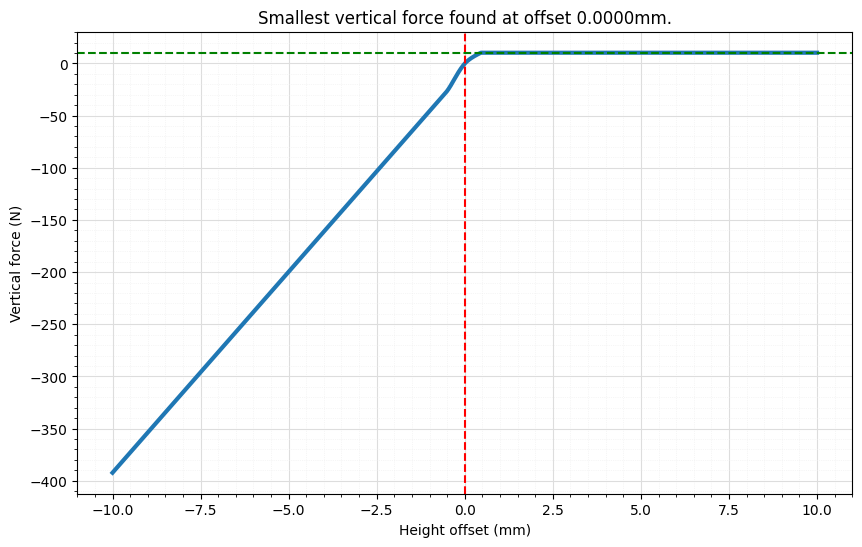

best_height: 0.10927 + 0.0 = 0.10927]
sim_model.nv: 14 sim_model.nu: 4 sim_model.nq: 15 sim_model.na: 0
sim_data.qpos: [0.      0.      0.10927 1.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     ] 
sim_data.qvel: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
sim_data.qacc: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 
sim_data.ctrl: [0. 0. 0. 0.]
sim_data.site_xpos: [[0. 0. 0.]] 
sim_data.site_xmat: [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
ang_euler: [0, 0, 0] quat: [0. 0. 0. 1.]
qpos0:
 [0.      0.      0.10927 1.      0.      0.      0.      0.      0.
 0.      0.      0.      0.      0.      0.     ]
ctrl0:
 [ 0.02606  0.02606 -0.      -0.     ] 
afrc_inv:
 [ 0.       0.      -0.12869  0.       0.00169  0.       0.02606  0.27317
 -0.00201 -0.       0.02606  0.27317 -0.00201 -0.     ]
actuator_moment_inv:
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [

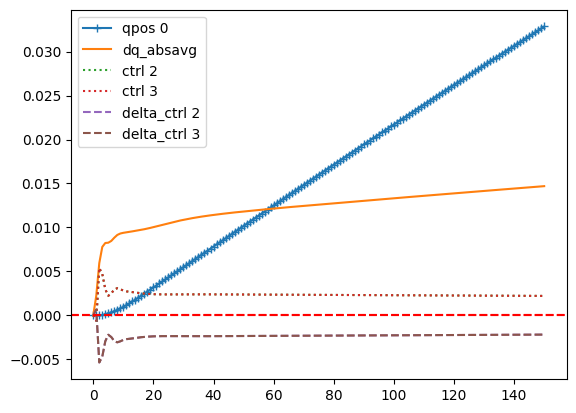

In [663]:
def simulate():

    CART_POLE_MJCF = "legwheel_robot2.xml" #"cartpole2.xml"
    sim_model = mujoco.MjModel.from_xml_path(CART_POLE_MJCF)
    sim_data = mujoco.MjData(sim_model)
    if False:
        mujoco.mj_resetDataKeyframe(sim_model, sim_data, 0)
    renderer = mujoco.Renderer(sim_model, height=int(480*1.5), width=int(640*1.5))

    best_offset = find_best_offset(sim_model, sim_data)
    best_height = sim_data.qpos[2] + best_offset
    print('best_height: {} + {} = {}]'.format(sim_data.qpos[2], best_offset, best_height))

    # Make a new camera, move it to a closer distance.
    camera = mujoco.MjvCamera()
    mujoco.mjv_defaultFreeCamera(sim_model, camera)
    camera.lookat = [0, -0.3, 0.21]
    camera.azimuth = 90
    camera.elevation = -30
    camera.distance = 2
    q0 = copy.copy(sim_data.qpos)

    print('sim_model.nv:', sim_model.nv, 'sim_model.nu:', sim_model.nu, 'sim_model.nq:', sim_model.nq, 'sim_model.na:', sim_model.na)  
    print('sim_data.qpos:', sim_data.qpos, '\nsim_data.qvel:', sim_data.qvel, '\nsim_data.qacc:', sim_data.qacc, '\nsim_data.ctrl:', sim_data.ctrl)
    print('sim_data.site_xpos:', sim_data.site_xpos, '\nsim_data.site_xmat:', sim_data.site_xmat)

    # Parameters.
    DURATION = 5  # seconds
    BALANCE_STD = 0.2  # actuator units
    FRAMERATE = 30
    
    ang_euler = Rotater.from_quat([0, 0, 0, 1]).as_euler('xyz', degrees=True)
    ang_euler = [0, 0, 0]
    quat = Rotater.from_euler('xyz', ang_euler, degrees=True).as_quat()
    print('ang_euler:', ang_euler, 'quat:', quat)

    # q0 = np.array([0.00683, -0.,       0.10429,  0.99998,  0.,       0.00578,  0.,       0.02409, -0.07825,  0.08276,  0.25267,  0.02409, -0.07825,  0.08276,  0.25267])
    init_h = best_height
    tgt_h = init_h
    qpos0 = np.array([0., 0., init_h*np.cos(ang_euler[1]*np.pi/180), quat[3], quat[0], quat[1], quat[2], 0, 0, 0, 0, 0, 0, 0., 0.]) #give initial pose
    target = np.array([0., 0., tgt_h, 1., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0., 0.]) #give target pose which is the stable pose
    #x, y, z
    # target[0] = 0.1#x
    # target[1] = 0.0 #y
    # target[2] = tgt_h #z
    #left and right wheel
    # target[10] = 1.0 #left wheel
    # target[14] = 1.0 #right wheel

    Q = np.eye(sim_model.nv*2) * 1e-6
    if True:
        root_q_pos_idx = [0, 1, 2]
        root_q_ori_idx = [3, 4, 5]
        root_v_pos_idx = [14, 15, 16]
        root_v_ori_idx = [17, 18, 19]
        thigh_q_idx = [6, 10]
        thigh_v_idx = [20, 24]
        wheel_q_idx = [9, 13]
        wheel_v_idx = [23, 27]
        diagidx = root_q_pos_idx + root_q_ori_idx + root_v_pos_idx + root_v_ori_idx + thigh_q_idx + thigh_v_idx + wheel_q_idx + wheel_v_idx
        # diagidx = root_q_pos_idx + root_q_ori_idx + root_v_pos_idx + root_v_ori_idx
    else:
        diagidx = list(range(sim_model.nv*2))
    Q[diagidx, diagidx] = 100
    R = np.eye(sim_model.nu) * 1

    dq = np.zeros(sim_model.nv)
    # mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
    # print('dq:', dq)
    # return

    # ctrl0, K = compute_gains(uncertain_model, uncertain_data, target)
    ctrl0, K = compute_gains(sim_model, sim_data, qpos0, Q, R)

    # return

    #print('ctrl0:', ctrl0, 'K:', K)

    # Reset data, set initial pose.
    mujoco.mj_resetData(sim_model, sim_data)
    sim_data.qpos = qpos0

    # Enable contact force visualisation.
    scene_option = mujoco.MjvOption()
    scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
    scene_option.frame = mujoco.mjtFrame.mjFRAME_WORLD

    qhist = []
    frames = []
    dqlist = []
    ctrlist = []
    delta_ctrlist = []

    while sim_data.time < DURATION:
        if False:
            ctrl0, K = compute_gains(sim_model, sim_data, sim_data.qpos, Q, R, False)
        print("====================================")
        # Get state difference dx.
        mujoco.mj_differentiatePos(sim_model, dq, 1, target, sim_data.qpos)
        dx = np.hstack((dq, sim_data.qvel)).T

        # LQR control law.
        ctrl_noise = np.random.randn(sim_model.nu)/5
        
        if False:
            #only consider the subset of dx
            #failed
            dx_subset = np.zeros_like(dx)
            dx_subset[diagidx] = dx[diagidx]
            delta_ctrl = K @ dx_subset
        else:
            delta_ctrl = K @ dx
        sim_data.ctrl = ctrl0 - delta_ctrl# + ctrl_noise
        # print('ctrl:', sim_data.ctrl)
        print('sim_data.time:', sim_data.time)
        

        # Step the simulation.
        mujoco.mj_step(sim_model, sim_data)

        print('dq:\n', dq, "\nsim_data.qpos:\n", sim_data.qpos, "\nsim_data.qvel:\n", sim_data.qvel, "\nsim_data.ctrl:\n", sim_data.ctrl)

        # Save history.
        if len(frames) < sim_data.time * FRAMERATE:
            qhist.append(sim_data.qpos.copy())
            dqlist.append(dq.copy())
            ctrlist.append(sim_data.ctrl.copy())
            delta_ctrlist.append(delta_ctrl.copy())
            #camera.lookat = sim_data.body('root').subtree_com
            renderer.update_scene(sim_data, camera, scene_option)
            img = renderer.render()
            #draw frame number on image
            cv2.putText(img, str(len(frames)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            frames.append(img)

    #draw plot image on the right side of frame
    plot_img = plot_curve(qhist, target, dqlist, ctrlist, delta_ctrlist, diagidx)
    #resize plot image to the one-third size of frame keeping ratio
    tgt_h = frames[0].shape[0]//3
    tgt_w = int(plot_img.shape[1] * tgt_h / plot_img.shape[0])
    rsz_plot = cv2.resize(plot_img, (tgt_w, tgt_h))
    for img in frames:
        img[:rsz_plot.shape[0], -rsz_plot.shape[1]:] = rsz_plot
    print("show video:")
    media.show_video(frames, fps=10)#FRAMERATE)
    
    
simulate()